### Imports

In [ ]:
import decimal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.constants as cst
import scipy.integrate as sc
from scipy.stats import norm


### Functions Definition

In [ ]:
# Evolution following the analytical evolution
def m_evolve_th(mass_init, time):
    G_g = cst.G / 1e+3  # [m^3/g/s^2]
    hbar_GeV = cst.hbar / 1.602176565e-10  # [GeV*s]

    c = (hbar_GeV * cst.c**4 / (5120 * cst.pi * G_g ** 2))
    return (mass_init ** 3 - (c * time)) ** (1/3)


def t_evolve_th(mass_init, mass):
    G_g = cst.G / 1e+3  # [m^3/g/s^2]
    hbar_GeV = cst.hbar / 1.602176565e-10  # [GeV*s]

    c = (hbar_GeV * cst.c**4 / (5120 * cst.pi * G_g ** 2))
    return (mass_init ** 3 - mass ** 3) / c


def temperature_th(mass_init, time):
    G_g = cst.G / 1e+3  # [m^3/g/s^2]
    k_GeV = cst.k / 1.602176565e-10  # [GeV/K]
    hbar_GeV = cst.hbar / 1.602176565e-10  # [GeV*s]

    return hbar_GeV * cst.c**3 / (8 * cst.pi * G_g * k_GeV * m_evolve_th(mass_init, time)) 


def mass_distribution_th(mass, dist_choice, total_mass, mass_min, mass_max, alpha):
    if dist_choice == 0:
        # Dirac delta distribution at mass_dist_mode
        if np.isclose(mass, (mass_max + mass_min) / 2, atol=1e-8):
            mass_dist_th = total_mass
        else:
            mass_dist_th = 0

    if dist_choice == 1:
        # Uniform distribution in mass_range
        if mass >= mass_min and mass <= mass_max:
            mass_dist_th = total_mass / (mass_max - mass_min)
        else:
            mass_dist_th = 0

    if dist_choice == 2:
        # Log-space uniform distribution
        if mass >= mass_min and mass <= mass_max:
            mass_dist_th = total_mass / (np.log(mass_max) - np.log(mass_min)) * (1 / mass)
        else:
            mass_dist_th = 0

    if dist_choice == 3:
        # Gaussian (normal) distribution
        if mass >= mass_min and mass <= mass_max:
            mu = (mass_max + mass_min) / 2
            sigma = (mass_max - mass_min) / (2 * 3) # 99.7% of values within [min, max]
            mass_dist_th = total_mass / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(mass - mu)**2 / (2 * sigma**2))
        else:
            mass_dist_th = 0

    if dist_choice == 4:
        # Log-space gaussian (normal) distribution
        if mass >= mass_min and mass <= mass_max:
            mu = np.log((mass_max + mass_min) / 2)
            sigma = np.log(mass_max / mass_min) / (2 * 3)
            norm_factor = norm.cdf((np.log(mass_max) - mu) / sigma) - norm.cdf((np.log(mass_min) - mu) / sigma)
            mass_dist_th = total_mass * (np.exp(-(np.log(mass) - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi) * mass)) / norm_factor
        else:
            mass_dist_th = 0

    if dist_choice == 5:
        # Power-law distribution    
        if mass >= mass_min and mass <= mass_max:
            if alpha == 1:
                mass_dist_th = total_mass / np.log(mass_max / mass_min) * (1 / mass)
            else:
                normalized = (mass_max**(1 - alpha) - mass_min**(1 - alpha)) / (1 - alpha)
                mass_dist_th = total_mass / normalized * (mass**(-alpha))
        else:
            mass_dist_th = 0

    if dist_choice == 6:
        # Weibull distribution
        raise ValueError("Weibull distribution is not yet implemented.")
    
    return mass_dist_th


def emission_rate_th(mass, time, energy, f_or_b):
    k_GeV = cst.k / 1.602176565e-10  # [GeV/K]
    hbar_GeV = cst.hbar / 1.602176565e-10  # [GeV*s]

    if f_or_b == 0:  # Fermionic
        return 1 / (2 * cst.pi * hbar_GeV * (np.exp(energy / (k_GeV * temperature_th(mass, time))) + 1))
    elif f_or_b == 1:  # Bosonic
        return 1 / (2 * cst.pi * hbar_GeV * (np.exp(energy / (k_GeV * temperature_th(mass, time))) - 1))
    else:
        raise ValueError("f_or_b must be either 0 (Fermionic) or 1 (Bosonic).")


def total_emission_rate_th(time, energy, f_or_b, dist_choice, total_mass, mass_min, mass_max, alpha):
    G_g = cst.G / 1e+3  # [m^3/g/s^2]
    hbar_GeV = cst.hbar / 1.602176565e-10  # [GeV*s]

    c = (hbar_GeV * cst.c**4 / (5120 * cst.pi * G_g ** 2))
    tau_max = t_evolve_th(mass_max, mass_min)
    integral = sc.quad(lambda tau: mass_distribution_th(m_evolve_th(mass_max, tau), dist_choice, total_mass, mass_min, mass_max, alpha)
                       * emission_rate_th(m_evolve_th(mass_max, tau), time, energy, f_or_b)
                       * (mass_max ** 3 - (c * tau)) ** (-2/3) * c / 3, 0, tau_max)[0]
    return integral


def differential_flux_th(energy, total_emission, distance=300*3.086e22):
    if distance <= 0:
        raise ValueError("Distance must be greater than zero.")
    return total_emission * energy ** 2 / (8 * cst.pi * distance**2)


In [ ]:
# Evolution following the BlackHawk table: life_evolution.txt
def idx_m_evolve(bh_mass, mass_init, time):
    idx_init = np.argmin(np.abs(mass_init - bh_mass[:, 1]))
    idx_final = []
    for i in range(len(time)):
        idx_final.append(np.argmin(np.abs(bh_mass[idx_init, 0] + time[i] - bh_mass[:, 0])))
    return idx_final


def idx_t_evolve(bh_mass, mass):
    idx_final = []
    for i in range(len(mass)):
        idx_final.append(np.argmin(np.abs(mass[i] - bh_mass[:, 1])))
    return idx_final


def mass_distribution(dist_choice, nb_bm, total_mass, mass_range, alpha):
    mass_dist_mode = total_mass / nb_bm
    
    log_min = np.round(np.log10(mass_dist_mode / mass_range), 14)
    log_max = np.round(np.log10(mass_dist_mode * mass_range), 14)

    if dist_choice == 0:
        # Dirac delta distribution at mass_dist_mode
        mass_dist = np.full(int(nb_bm), mass_dist_mode)

    if dist_choice == 1:
        # Uniform distribution in mass_range
        mass_dist = np.random.uniform(mass_dist_mode / mass_range, mass_dist_mode * mass_range, int(nb_bm))

    if dist_choice == 2:
        # Log-space uniform distribution
        mass_dist = 10 ** np.random.uniform(log_min, log_max, int(nb_bm))

    if dist_choice == 3:
        # Gaussian (normal) distribution
        mu = mass_dist_mode
        sigma = (mass_range * mass_dist_mode) / 6  # 99.7% of values within [min, max]
        mass_dist = np.random.normal(mu, sigma, int(nb_bm))
        mass_dist = np.clip(mass_dist, mass_dist_mode / mass_range, mass_dist_mode * mass_range)

    if dist_choice == 4:
        # Log-space gaussian (normal) distribution
        mu = np.log10(mass_dist_mode)
        sigma = (log_max - log_min) / 6  # 99.7% of values within [log_min, log_max]
        log_masses = np.random.normal(mu, sigma, int(nb_bm))
        mass_dist = 10 ** np.clip(log_masses, log_min, log_max)

    if dist_choice == 5:
        # Power-law distribution    
        log_masses = np.random.power(alpha, int(nb_bm)) * (log_max - log_min) + log_min
        mass_dist = 10 ** log_masses

    if dist_choice == 6:
        # Weibull distribution
        raise ValueError("Weibull distribution is not yet implemented.")
    
    return np.sort(mass_dist)[::-1] * (total_mass / np.sum(mass_dist))


def fix_and_load_txt(path, txt, lines_skip=1, change_back=False):
    with open(path, 'r') as f:
        lines = f.readlines()

    if change_back:
        if txt in lines[1:3]:
            return None
        
        with open(path, 'r') as f:
            lines = f.readlines()
        replaced = False
        for idx in range(1, 3):
            if not replaced and '0' in lines[idx]:
                lines[idx] = lines[idx].replace('0', txt, 1)
                replaced = True
        with open(path, 'w') as f:
            f.writelines(lines)
        return None

    if not txt == None:
        lines[1:3] = [line.replace(txt, '0', 1) for line in lines[1:3]]
        with open(path, 'w') as f:
            f.writelines(lines)
    return np.loadtxt(path, skiprows=lines_skip)


def GetSpacedElements(array, numElems, unique=True):
    if unique:
    # Remove duplicates if unique is True
        array = np.array(list(dict.fromkeys(array)))
    indices = np.round(np.linspace(0, len(array) - 1, numElems)).astype(int)
    values = array[indices]
    return values, indices


def precision(d):
    dec = decimal.Decimal(str(d))
    return 10**dec.as_tuple().exponent


def critical_point(spectrum_1, spectrum_2, t_idx, threshold=1e+1, fix=None):
    if spectrum_2 is None:
        return [np.full(len(t_idx), len(spectrum_1)), np.full(len(t_idx), len(spectrum_2))]

    if fix is not None:
        x_crit_1 = np.full(len(t_idx), np.where(spectrum_1[0, 1:] >= fix)[0][0] + 1)
        x_crit_2 = np.full(len(t_idx), max(1, np.where(spectrum_2[0, 1:] >= fix)[0][0] + 1))
        return [x_crit_1, x_crit_2]
    
    # Find index for matching energy in both spectra
    idx_below_1 = np.where(spectrum_1[0, 1:] >= 1e-2)[0][0] + 1
    idx_below_2 = np.where(spectrum_2[0, 1:] >= 1e-2)[0][0] + 1
    idx_1 = np.linspace(idx_below_1, len(spectrum_1[0, 1:]) - 1, num=len(spectrum_1[0, 1:]) - idx_below_1, dtype=int)
    idx_2 = []
    # Find the index in spectrum_2 that is closest to spectrum_1[idx_1[i]]
    for i in range(len(idx_1)):
        idx_closest = np.argmin(np.abs(spectrum_2[0, idx_below_2:] - spectrum_1[0, idx_1[i]]))
        idx_2.append(idx_closest + idx_below_2)

    # Find the indices where the spectra difference exceed the threshold
    x_crit_1 = []
    x_crit_2 = []
    for i in t_idx:
        diff = spectrum_1[i, idx_1] / spectrum_2[i, idx_2]
        if min(diff) > threshold:
            raise ValueError(f"Minimum difference between spectra at time index {i} is above the threshold.")
        x_crit_1.append(idx_1[np.where(diff <= threshold)[0][0]])
        x_crit_2.append(idx_2[np.where(diff <= threshold)[0][0]])
    return [x_crit_1, x_crit_2]


def convert_to_cgs(spectrum):
    gev_to_erg = np.full_like(spectrum, 0.001602176565)
    m_to_cm = np.full_like(spectrum, 1e+2)
    # Convert GeV to erg and m^2 to cm^2
    return spectrum * gev_to_erg / m_to_cm ** 2


def flux_mass_distribution(bh_mass, mass_dist, t_obs_idx, x_crit_1, x_crit_2, table_idx, flux_1=None, flux_2=None):
    t_idx_init = idx_t_evolve(bh_mass, mass_dist)
    t_init = bh_mass[idx_t_evolve(bh_mass, mass_dist), 0]
    t_precision = precision(max(bh_mass[:, 0]))

    e_idx_min_2 = []
    e_idx_max_1 = []

    if table_idx == 1:
        if type(flux_1) != np.ndarray:
            raise ValueError(f"Argument flux_1 = {flux_1} must be specified.")
        t_obs = flux_1[t_obs_idx, 0]
        flux_mass_dist = np.zeros_like(flux_1[t_obs_idx, 1:])
        if type(flux_2) != np.ndarray:
            for i in range(len(mass_dist)):
                t_idx = np.argmin(np.abs(flux_1[1:, 0] - (t_init[i] + t_obs))) + 1
                if t_idx_init[i] > t_idx:
                    if t_obs >= t_precision:
                        continue
                    flux_mass_dist += flux_1[t_idx_init[i], 1:]
                    continue
                flux_mass_dist += flux_1[t_idx, 1:]
            return flux_mass_dist
            
        else:
            e_idx_offset_min = []
            e_idx_offset_max = []
            for i in range(len(mass_dist)):
                t_idx = np.argmin(np.abs(flux_1[1:, 0] - (t_init[i] + t_obs))) + 1
                e_idx_min_2.append(x_crit_2[t_idx])
                e_idx_max_1.append(x_crit_1[t_idx] + 1)
                e_idx_offset_min.append(np.where(flux_1[0, e_idx_min_2[i]:e_idx_max_1[i]] - flux_2[0, e_idx_min_2[i]] >= 0)[0])
                e_idx_offset_max.append(np.where(flux_2[0, e_idx_min_2[i]:e_idx_max_1[i]] - flux_1[0, e_idx_max_1[i]] >= 0)[0])
                flux_2_mapped = flux_2.copy()
                if len(e_idx_offset_min[i]) > 0:
                    if len(e_idx_offset_max[i]) == 0:
                        raise ValueError("Oups...")
                    e_idx_offset_min[i] = e_idx_offset_min[i][0] - 1
                    e_idx_offset_max[i] = e_idx_offset_max[i][0] - 1
                    # error = []
                    e_idx_correction = []
                    for idx in range(len(flux_1[0, e_idx_min_2[i] + e_idx_offset_min[i]:e_idx_max_1[i]])):
                        e_idx_correction.append(np.argmin(np.abs(flux_2[0, e_idx_min_2[i]:e_idx_min_2[i] + e_idx_offset_max[i]] - flux_1[0, e_idx_min_2[i] + e_idx_offset_min[i]:e_idx_max_1[i]][idx])))
                        # error.append(100 * np.abs(flux_1[0, e_idx_min_2[i] + e_idx_offset_min[i]:e_idx_max_1[i]][idx] - flux_2[0, e_idx_min_2[i]:e_idx_min_2[i] + e_idx_offset_max[i]][e_idx_correction[idx]]) / flux_2[0, e_idx_min_2[i]:e_idx_min_2[i] + e_idx_offset_max[i]][e_idx_correction[idx]])
                        flux_2_mapped[0, e_idx_min_2[i] + idx] = flux_2_mapped[0, e_idx_min_2[i] + e_idx_correction[idx]]
                        flux_2_mapped[t_idx_init[i], e_idx_min_2[i] + idx] = flux_2_mapped[t_idx_init[i], e_idx_min_2[i] + e_idx_correction[idx]]
                        flux_2_mapped[t_idx, e_idx_min_2[i] + idx] = flux_2_mapped[t_idx, e_idx_min_2[i] + e_idx_correction[idx]]
                    # print(f"Maximum error made by the energy mapping: {max(error):.2f}%")
                if t_idx_init[i] > t_idx:
                    if t_obs >= t_precision:
                        continue
                    flux_mass_dist += np.pad(flux_1[t_idx_init[i], 1:x_crit_1[t_idx_init[i]]], (0, len(flux_mass_dist) - len(flux_1[t_idx_init[i], 1:x_crit_1[t_idx_init[i]]])))
                    flux_mass_dist += np.pad(flux_2_mapped[t_idx_init[i], x_crit_2[t_idx_init[i]]:], (x_crit_1[t_idx_init[i]] - 1, 0))[:len(flux_mass_dist)]
                    continue
                flux_mass_dist += np.pad(flux_1[t_idx, 1:x_crit_1[t_idx]], (0, len(flux_mass_dist) - len(flux_1[t_idx, 1:x_crit_1[t_idx]])))
                flux_mass_dist += np.pad(flux_2_mapped[t_idx, x_crit_2[t_idx]:], (x_crit_1[t_idx] - 1, 0))[:len(flux_mass_dist)]
            return flux_mass_dist[:max(e_idx_max_1)]
    
    if table_idx == 2:
        if (type(flux_1) or type(flux_2)) != np.ndarray:
            raise ValueError(f"Argument flux_1 = {flux_1} and flux_2 = {flux_2} must be specified.")
        t_obs = flux_2[t_obs_idx, 0]
        flux_mass_dist = np.zeros_like(flux_2[t_obs_idx, 1:])
        for i in range(len(mass_dist)):
            t_idx = np.argmin(np.abs(flux_2[1:, 0] - (t_init[i] + t_obs))) + 1
            e_idx_max_1.append(x_crit_1[t_idx] + 1)
            if t_idx_init[i] > t_idx:
                if t_obs >= t_precision:
                    continue
                flux_mass_dist += np.pad(flux_2[t_idx_init[i], x_crit_2[t_idx_init[i]]:], (len(flux_mass_dist) - len(flux_2[t_idx_init[i], x_crit_2[t_idx_init[i]]:]), 0))
                continue
            flux_mass_dist += np.pad(flux_2[t_idx, x_crit_2[t_idx]:], (len(flux_mass_dist) - len(flux_2[t_idx, x_crit_2[t_idx]:]), 0))
        return flux_mass_dist[np.argmin(np.abs(flux_2[0, 1:] - flux_1[0, max(e_idx_max_1)])):]
    
    else:
        raise ValueError(f"table_idx = {table_idx}, but must be either 1 for PYTHIA or 2 for HDMSpectra.")


def differential_flux(flux_mass_dist, energy, D=300 * 3.0856775814913670e+22):
    diff_flux = []
    for i in range(len(flux_mass_dist)):
        diff_flux.append(energy[i] ** 2 * flux_mass_dist[i] / (8 * np.pi * D**2))
    return diff_flux


### Mass Distribution & Tables Parameters Definition

In [ ]:
dist_choice = 5										# Mass distribution types: 0:"dirac", 1:"uniform", 2:"log-uniform", 3:"normal", 4:"log-normal", 5:"powerlaw", 6:"weibull"
nb_bm = 1e+3										# Number of black hole morsels
total_mass = 2e+12									# Total mass of black hole morsels in [g], must be greater than 1 g per morsel
mass_range = 1e+1									# Maximum order of discrepancy (before renormalisation) from: total_mass / nb_bm
													# (e.i. mass_range = 10 -> maximum mass: mass_dist_mode x10, minimum mass: mass_dist_mode /10)
alpha = 8.0											# Power-law index

mass_dist = mass_distribution(dist_choice, nb_bm, total_mass, mass_range, alpha)
print(f"Morsels mass range: [{np.min(mass_dist):.2e}, {np.max(mass_dist):.2e}] g")


test_name_1 = "test5_PYTHIA"						# Change this to the desired test name, e.g., 'test1', 'test2', etc.
test_name_2 = "test5_HDMS"							# Change this to the desired test name, e.g., 'test2', 'test3', etc. or None if not needed

time_extention = False								# True: extends time precision in mass evolution, False: keeps original time precision
test_name_1_extended = "test5_extended_PYTHIA"		# Adds precision to late times in mass evolution, e.g., 'test1_extended'
test_name_2_extended = "test5_extended_HDMS"		# Adds precision to late times in mass evolution, e.g., 'test1_extended' or None if not needed

n = 17												# Number of spaced times to extract from the spectrum
threshold_primary = 1e+1							# Primary threshold for the critical point detection, gets overuled by fix_primary
threshold_secondary = 1.001e+0						# Secondary threshold for the critical point detection, gets overuled by fix_secondary
fix_primary = 5e+3									# Primary fix value for the critical point in [GeV], or None if not needed
fix_secondary = None								# secondary fix value for the critical point in [GeV], or None if not needed


Morsels mass range: [2.55e+08, 3.04e+09] g


### BlackHawk Data Import & Tables' Range Definition

In [55]:
mass_evolution_1 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1}/life_evolutions.txt', None, lines_skip=4)
photon_primary_spectrum_1 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1}/photon_primary_spectrum.txt', 'time/energy')
photon_secondary_spectrum_1 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1}/photon_secondary_spectrum.txt', 'time/energy')

fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1}/photon_primary_spectrum.txt', 'time/energy', change_back=True)
fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1}/photon_secondary_spectrum.txt', 'time/energy', change_back=True)

if test_name_2 is not None:
    mass_evolution_2 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2}/life_evolutions.txt', None, lines_skip=4)
    photon_primary_spectrum_2 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2}/photon_primary_spectrum.txt', 'time/energy')
    photon_secondary_spectrum_2 = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2}/photon_secondary_spectrum.txt', 'time/energy')

    fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2}/photon_primary_spectrum.txt', 'time/energy', change_back=True)
    fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2}/photon_secondary_spectrum.txt', 'time/energy', change_back=True)

    if not mass_evolution_1[1, 1] == mass_evolution_2[1, 1]:
        raise ValueError("The black hole spectra for the two tests do not match.")

if time_extention:
    mass_evolution_1_extended = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_1_extended}/life_evolutions.txt', None, lines_skip=4)

    idx_low_res = np.argmin(np.abs(mass_evolution_1[:, 1] - mass_evolution_1_extended[0, 1]))
    time_add_res = np.interp(np.flip(mass_evolution_1[idx_low_res:, 1]), np.flip(mass_evolution_1_extended[:, 1]), np.flip(mass_evolution_1_extended[:, 0]))
    
    mass_evolution_1[idx_low_res:, 0] = mass_evolution_1[idx_low_res, 0] + np.flip(time_add_res)
    photon_primary_spectrum_1[idx_low_res + 1:, 0] = photon_primary_spectrum_1[idx_low_res + 1, 0] + np.flip(time_add_res)
    photon_secondary_spectrum_1[idx_low_res + 1:, 0] = photon_secondary_spectrum_1[idx_low_res + 1, 0] + np.flip(time_add_res)

    if test_name_2 is not None:
        mass_evolution_2_extended = fix_and_load_txt(f'blackhawk_v2.3/results/{test_name_2_extended}/life_evolutions.txt', None, lines_skip=4)

        if not mass_evolution_1_extended[1, 1] == mass_evolution_2_extended[1, 1]:
            raise ValueError("The extended black hole spectra for the two tests do not match.")
        
        mass_evolution_2[idx_low_res:, 0] = mass_evolution_2[idx_low_res, 0] + np.flip(time_add_res)
        photon_primary_spectrum_2[idx_low_res + 1:, 0] = photon_primary_spectrum_2[idx_low_res + 1, 0] + np.flip(time_add_res)
        photon_secondary_spectrum_2[idx_low_res + 1:, 0] = photon_secondary_spectrum_2[idx_low_res + 1, 0] + np.flip(time_add_res)
        
if mass_evolution_1[1,1] < max(mass_dist):
    raise ValueError("The mass distribution ranges higher than the BlackHawk computed data.")

j, k = GetSpacedElements(photon_primary_spectrum_1[1:, 0], n, unique=True)
j, k, n = np.append(j, photon_primary_spectrum_1[-1, 0]), np.append(k, len(photon_primary_spectrum_1[1:, 0]) - 2), n + 1

x_crit_primary_1, x_crit_primary_2 = critical_point(photon_primary_spectrum_1, photon_primary_spectrum_2, range(len(photon_primary_spectrum_1[1:, 0])), threshold=threshold_primary, fix=fix_primary)
x_crit_secondary_1, x_crit_secondary_2 = critical_point(photon_secondary_spectrum_1, photon_secondary_spectrum_2, range(len(photon_primary_spectrum_1[1:, 0])), threshold=threshold_secondary, fix=fix_secondary)


In [ ]:
# Add both hadronization tables with correct "interpolation" (or simple mapping for rough version) for second spectrum
# WARNING: if overlap with hadronization tables energies -> double counting!
if test_name_2 is not None:
    photon_primary_spectrum = np.zeros((len(photon_primary_spectrum_1[:, 0]), len(photon_primary_spectrum_1[0, :-1]) + len(photon_primary_spectrum_2[0, 1:])))
    photon_primary_spectrum[1:, 0] = photon_primary_spectrum_1[1:, 0]
    for i in range(len(photon_primary_spectrum[:, 0])):
        photon_primary_spectrum[i, 1:] = np.concatenate([photon_primary_spectrum_1[i, 1:-1], photon_primary_spectrum_2[i, 1:]])
    
    e_2 = np.where(photon_secondary_spectrum_2[0, :] - photon_secondary_spectrum_1[0, -1] >= 0)[0][0]
    photon_secondary_spectrum = np.zeros((len(photon_secondary_spectrum_1[:, 0]), len(photon_secondary_spectrum_1[0, :]) + len(photon_secondary_spectrum_2[0, e_2:])))
    photon_secondary_spectrum[1:, 0] = photon_secondary_spectrum_1[1:, 0]
    photon_secondary_spectrum[0, 1:] = np.concatenate([photon_secondary_spectrum_1[0, 1:], photon_secondary_spectrum_2[0, e_2:]])
    for i in range(len(photon_secondary_spectrum[1:, 0])):
        photon_secondary_spectrum[i + 1, 1:len(photon_secondary_spectrum_1[0, :])] = photon_secondary_spectrum_1[i + 1, 1:] + np.interp(photon_secondary_spectrum_1[0, 1:], photon_secondary_spectrum_2[0, 1:], photon_secondary_spectrum_2[i + 1, 1:])
        photon_secondary_spectrum[i + 1, len(photon_secondary_spectrum_1[0, :]):] = photon_secondary_spectrum_2[i + 1, e_2:] + np.interp(photon_secondary_spectrum_2[0, e_2:], photon_secondary_spectrum_1[0, 1:], photon_secondary_spectrum_1[i + 1, 1:])
else:
    photon_primary_spectrum = photon_primary_spectrum_1
    photon_secondary_spectrum = photon_secondary_spectrum_1


### Graph Emission Rate: BlackHawk

C:\Users\felix\AppData\Local\Temp\ipykernel_18424\442969386.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


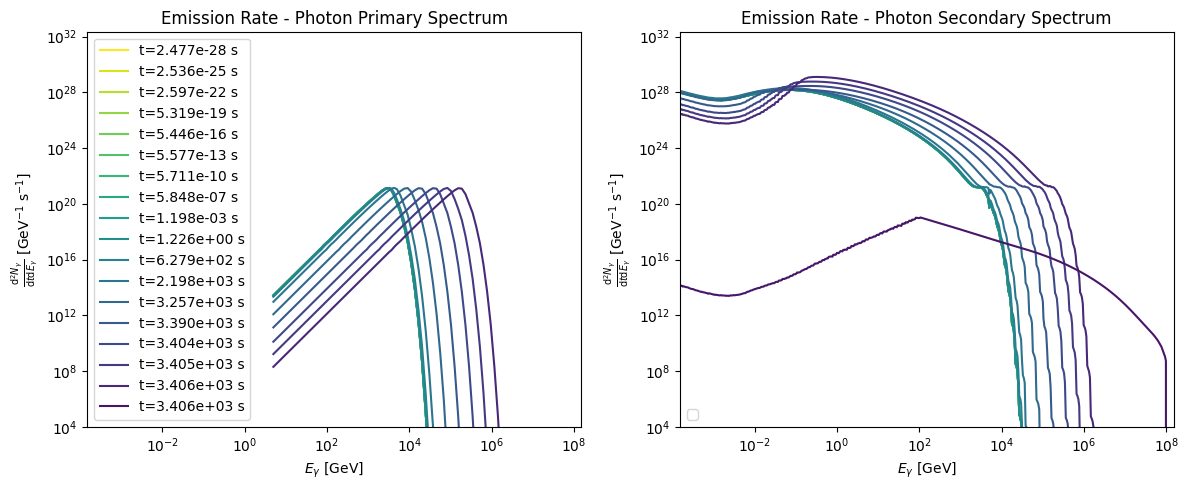

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(n):
    plt.plot(photon_primary_spectrum[0,1:],
             photon_primary_spectrum[k[i] + 1, 1:],
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Emission Rate - Photon Primary Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$\\frac{\\text{d}^2N_{\\gamma}}{\\text{d}t\\text{d}E_{\\gamma}}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+32)
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
for i in range(n):
    plt.plot(photon_secondary_spectrum_1[0,1:x_crit_secondary_1[k[i] + 1]],
             photon_secondary_spectrum_1[k[i] + 1, 1:x_crit_secondary_1[k[i] + 1]],
             color="red",
             label="Junction" if i==n-1 else None)
    if test_name_2 is not None:
        plt.plot(photon_secondary_spectrum_2[0,x_crit_secondary_2[k[i] + 1]:],
                 photon_secondary_spectrum_2[k[i] + 1, x_crit_secondary_2[k[i] + 1]:],
                 color="red",
                 linestyle='-')
    plt.plot(photon_secondary_spectrum[0, 1:],
             photon_secondary_spectrum[k[i] + 1, 1:],
             color=plt.cm.viridis_r(i / n),
             linestyle='-',
             label="Summation" if i==n-1 and True else None)
plt.title('Emission Rate - Photon Secondary Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$\\frac{\\text{d}^2N_{\\gamma}}{\\text{d}t\\text{d}E_{\\gamma}}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+32)
plt.legend(loc='lower left')
plt.tight_layout()

plt.savefig('figures/photon_emission_rate.png', dpi=300)


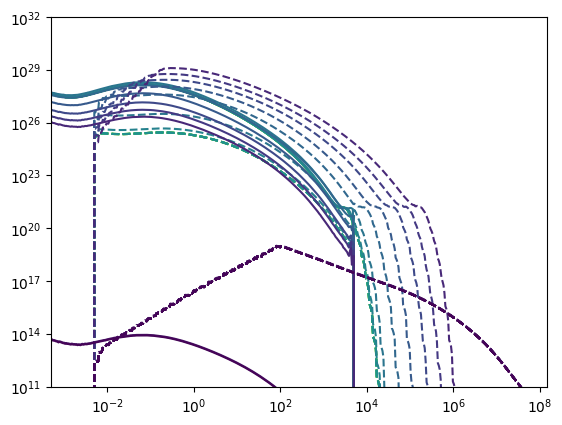

In [8]:
for i in range(n):
    plt.plot(photon_secondary_spectrum_1[0,1:],
             photon_secondary_spectrum_1[k[i] + 1, 1:],
             color=plt.cm.viridis_r(i / n))
    plt.plot(photon_secondary_spectrum_2[0,1:],
             photon_secondary_spectrum_2[k[i] + 1, 1:],
             color=plt.cm.viridis_r(i / n), linestyle='--')
    plt.plot(photon_secondary_spectrum_2[0,1:], photon_secondary_spectrum_2[-1,1:],
             label='HDMSpectra',
             color=plt.cm.viridis_r(0.99),
             linestyle='--')
plt.plot(photon_secondary_spectrum_1[0,1:],
         photon_secondary_spectrum_1[-1,1:],
         label='PYTHIA',
         color=plt.cm.viridis_r(0.99))
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5e-3, 1.5e+8)
plt.ylim(1e+11, 1e+32)
plt.show()


### Graph Total Emission Rate

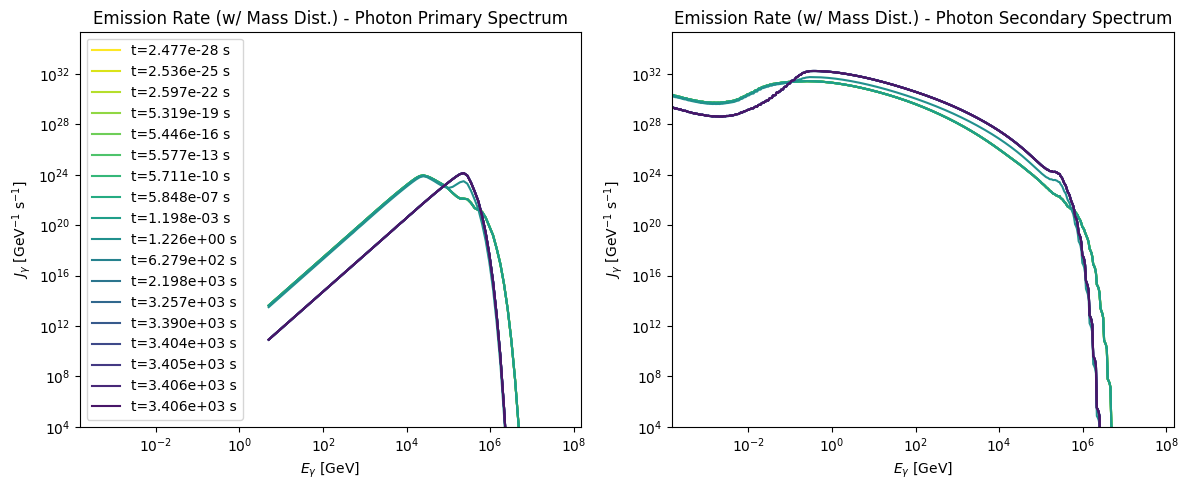

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(n):
    plt.plot(photon_primary_spectrum[0, 1:],
             flux_mass_distribution(mass_evolution_1, mass_dist, k[i] + 1, x_crit_primary_1, x_crit_primary_2, 1, flux_1=photon_primary_spectrum),
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Emission Rate (w/ Mass Dist.) - Photon Primary Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$J_{\\gamma}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+32 * nb_bm)
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
for i in range(n):
    plt.plot(photon_secondary_spectrum[0, 1:],
             flux_mass_distribution(mass_evolution_1, mass_dist, k[i] + 1, x_crit_secondary_1, x_crit_secondary_2, 1, flux_1=photon_secondary_spectrum),
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Emission Rate (w/ Mass Dist.) - Photon Secondary Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$J_{\\gamma}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+32 * nb_bm)
plt.tight_layout()

plt.savefig('figures/photon_emission_rate_mass.png', dpi=300)


### Graph Total Differential Flux

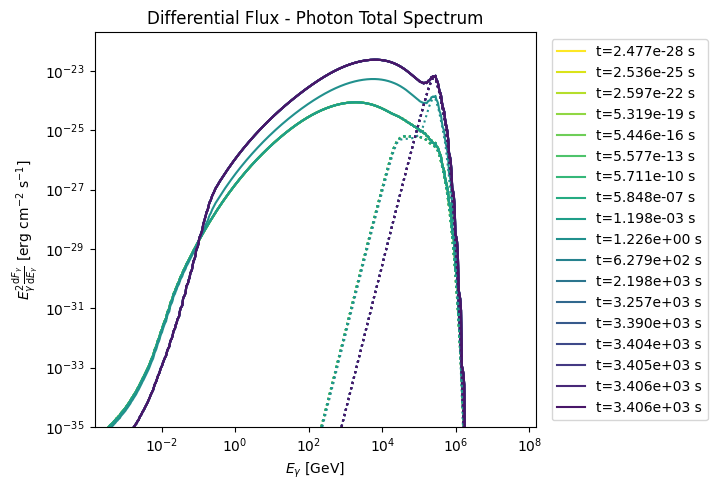

In [ ]:
plt.figure(figsize=(7.3, 5))
for i in range(n):
    plt.plot(photon_primary_spectrum[0, 1:],
             convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, mass_dist, k[i] + 1, x_crit_primary_1, x_crit_primary_2, 1, flux_1=photon_primary_spectrum), photon_primary_spectrum[0, 1:])),
             color=plt.cm.viridis_r(i / n),
             linestyle=':')

    plt.plot(photon_secondary_spectrum[0, 1:],
             convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, mass_dist, k[i] + 1, x_crit_secondary_1, x_crit_secondary_2, 1, flux_1=photon_secondary_spectrum), photon_secondary_spectrum[0, 1:])),
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Differential Flux - Photon Total Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$E^2_{\\gamma} \\frac{\\text{d}F_{\\gamma}}{\\text{d}E_{\\gamma}}$ [erg cm$^{-2}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e-38 * nb_bm, 2e-25 * nb_bm * (1e+4 if time_extention else 1))
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig('figures/photon_total_differential_flux.png', dpi=300)


### Graph Total Differential Flux: Evolution Comparison

Distribution 0 morsels mass range: [2.00e+09, 2.00e+09] g
Distribution 1 morsels mass range: [4.25e+07, 4.00e+09] g
Distribution 2 morsels mass range: [8.94e+07, 8.86e+09] g
Distribution 3 morsels mass range: [1.64e+08, 9.63e+09] g
Distribution 4 morsels mass range: [1.53e+08, 1.53e+10] g
Distribution 5 morsels mass range: [2.47e+08, 3.10e+09] g


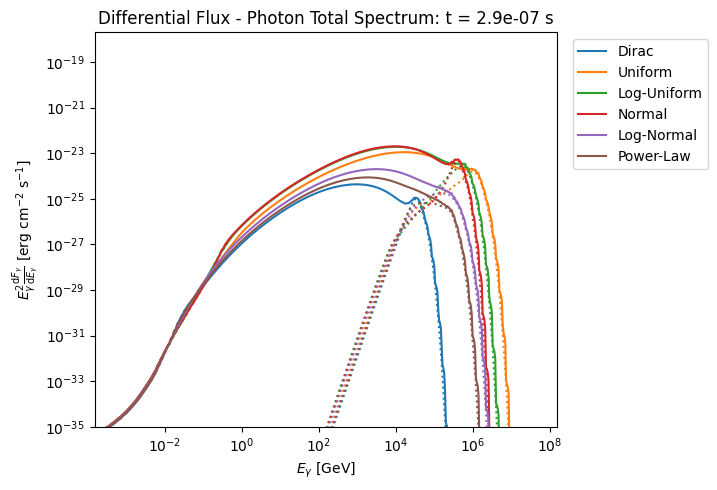

In [ ]:
dist_type = {0:"Dirac", 1:"Uniform", 2:"Log-Uniform", 3:"Normal", 4:"Log-Normal", 5:"Power-Law"}
multi_mass_dist = np.zeros((len(mass_dist), 6))
lines_primary = [None] * 6
lines_secondary = [None] * 6

fig= plt.figure(figsize=(7.3, 5))
for dist_idx in range(6):
    multi_mass_dist[:,dist_idx] = mass_distribution(dist_idx, nb_bm, total_mass, mass_range, alpha)
    print(f"Distribution {dist_idx} morsels mass range: [{np.min(multi_mass_dist[:,dist_idx]):.2e}, {np.max(multi_mass_dist[:,dist_idx]):.2e}] g")
    
    lines_primary[dist_idx], = plt.plot(photon_primary_spectrum[0, 1:],
                                          convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], k[0] + 1, x_crit_primary_1, x_crit_primary_2, 1, flux_1=photon_primary_spectrum), photon_primary_spectrum[0, 1:])),
                                          color=plt.cm.tab10(dist_idx / 10),
                                          linestyle=':')
    
    lines_secondary[dist_idx], = plt.plot(photon_secondary_spectrum[0, 1:],
                                          convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], k[0] + 1, x_crit_secondary_1, x_crit_secondary_2, 1, flux_1=photon_secondary_spectrum), photon_secondary_spectrum[0, 1:])),
                                          color=plt.cm.tab10(dist_idx / 10),
                                          label=f'{dist_type[dist_idx]}')
plt.title(f'Differential Flux - Photon Total Spectrum: t = {j[0]:.1e} s')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$E^2_{\\gamma} \\frac{\\text{d}F_{\\gamma}}{\\text{d}E_{\\gamma}}$ [erg cm$^{-2}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e-38 * nb_bm, 2e-25 * nb_bm * 1e+4)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


def animate_differential_flux(i):
    i = i + 70
    t = photon_primary_spectrum_1[1:, 0][i]

    for dist_idx in range(6):
        x_primary = photon_primary_spectrum[0, 1:]
        y_primary = convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], i, x_crit_primary_1, x_crit_primary_2, 1, flux_1=photon_primary_spectrum), photon_primary_spectrum[0, 1:]))

        x_secondary = photon_secondary_spectrum[0, 1:]
        y_secondary = convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], i, x_crit_secondary_1, x_crit_secondary_2, 1, flux_1=photon_secondary_spectrum), photon_secondary_spectrum[0, 1:]))

        lines_primary[dist_idx].set_data(x_primary, y_primary)
        lines_secondary[dist_idx].set_data(x_secondary, y_secondary)

    plt.title(f'Differential Flux - Photon Total Spectrum: t = {t:.1e} s')
    return lines_primary, lines_secondary


ani = animation.FuncAnimation(fig, animate_differential_flux, frames=100, interval=100)
ani.save('figures/photon_f_mass_distribution_comparison.gif', writer='pillow', fps=10)


C:\Users\felix\AppData\Local\Temp\ipykernel_18424\1796520785.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(data), delim_whitespace=True)


Total mass: 2.00e+23 g
Distribution 0 morsels mass range: [2.00e+09, 2.00e+09] g
Distribution 1 morsels mass range: [4.17e+07, 3.92e+09] g
Distribution 2 morsels mass range: [9.22e+07, 9.19e+09] g
Distribution 3 morsels mass range: [1.49e+08, 1.14e+10] g
Distribution 4 morsels mass range: [1.81e+08, 1.49e+10] g
Distribution 5 morsels mass range: [2.62e+08, 3.07e+09] g


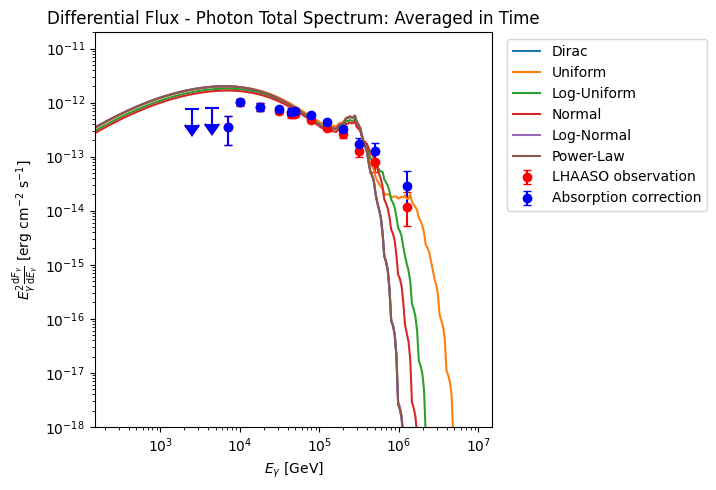

In [ ]:
import pandas as pd
from io import StringIO

plt.figure(figsize=(7.3, 5))
data = """
E(TeV) Eerr1 Eerr2 F(1/TeV/cm2/s) Ferr1 Ferr2 TS likefix likefree
2.51 -1.79 6.20 7.570e-14 0.000e+00 0.000e+00 0.0 -556.2 -556.2
4.47 -3.15 10.67 2.462e-14 0.000e+00 0.000e+00 2.9 -1502.2 -1502.2
7.08 -4.62 13.34 4.484e-15 -2.479e-15 2.503e-15 5.3 -1338.6 -1338.6
10.00 -5.53 12.39 6.421e-15 -9.337e-16 9.513e-16 76.4 -1481.7 -1481.7
17.78 -8.66 16.89 1.634e-15 -2.703e-16 2.813e-16 62.1 -1117.2 -1117.2
44.67 -25.61 60.04 1.907e-16 -2.675e-17 2.838e-17 104.9 -380.4 -380.4
31.62 -9.75 14.09 4.391e-16 -5.710e-17 5.795e-17 97.3 -1279.7 -1279.7
50.12 -14.64 20.68 1.549e-16 -1.500e-17 1.548e-17 205.2 -1609.3 -1609.3
79.43 -21.89 30.21 4.796e-17 -4.268e-18 4.424e-18 295.0 -1013.8 -1013.8
125.89 -32.57 43.93 1.344e-17 -1.426e-18 1.511e-18 278.3 -684.1 -684.1
199.53 -48.17 63.50 4.050e-18 -5.562e-19 6.057e-19 218.6 -330.6 -330.6
316.23 -70.76 91.15 8.113e-19 -1.832e-19 2.111e-19 66.3 -157.3 -157.3
501.19 -103.08 129.77 1.968e-19 -6.597e-20 8.319e-20 34.1 -44.2 -44.2
1258.93 -368.36 520.72 4.680e-21 -2.647e-21 4.237e-21 11.4 -12.7 -12.7
"""

df = pd.read_csv(StringIO(data), delim_whitespace=True)

# 计算转换后的数据
E_new = df["E(TeV)"] * 1e12  # eV
F_new = df["F(1/TeV/cm2/s)"] * df["E(TeV)"]**2 * 1.602  # erg/cm²/s
Ferr2_new = df["Ferr2"] * df["E(TeV)"]**2 * 1.602  # 误差上界
Ferr1_new = abs(df["Ferr1"]) * df["E(TeV)"]**2 * 1.602  # 误差下界
UL_flag = np.where((df["Ferr1"] == 0) & (df["Ferr2"] == 0), 1, 0)  # 上限标记

# --------------------------------------------- 绘图 --------------------------------------------- #
# **区分数据点和上限点**
mask_data = UL_flag == 0  # 数据点
mask_upper = UL_flag == 1  # 上限点
F_upper_err = 0.5 * F_new[mask_upper]  # 上限误差（设为 50%）

# **数据点**
plt.errorbar(E_new[mask_data]/1e9, F_new[mask_data], 
             yerr=[Ferr1_new[mask_data], Ferr2_new[mask_data]], 
             fmt='o', color='red', capsize=3, label="LHAASO observation")

# **上限点
plt.errorbar(E_new[mask_upper]/1e9, F_new[mask_upper], yerr=F_upper_err, 
             fmt='None', color='r', uplims=True, capsize=5, capthick=1.5)
# ----------------------------------------------------------------------------------------- #

absorb = [1.0, 1.0, 1.0, 0.991, 0.98, 0.893, 0.94, 0.875, 0.819, 0.795, 0.792, 0.75, 0.634, 0.418]  # calculated based on Popescu et al. 2017
F_new = np.array(F_new)/np.array(absorb)
Ferr2_new = np.array(Ferr2_new)/np.array(absorb)
Ferr1_new = np.array(Ferr1_new)/np.array(absorb)

# --------------------------------------------- 绘图 --------------------------------------------- #
mask_data = UL_flag == 0  # 数据点
mask_upper = UL_flag == 1  # 上限点
F_upper_err = 0.5 * F_new[mask_upper]  

# **数据点**
plt.errorbar(E_new[mask_data]/1e9, F_new[mask_data], 
             yerr=[Ferr1_new[mask_data], Ferr2_new[mask_data]], 
             fmt='o', color='b', capsize=3, label="Absorption correction")

# **上限点
plt.errorbar(E_new[mask_upper]/1e9, F_new[mask_upper], yerr=F_upper_err, 
             fmt='None', color='b', uplims=True, capsize=5, capthick=1.5)

#################################################################################################################################

nb_bm_total = 1e+14
nb_bm_more = nb_bm_total / nb_bm
print(f"Total mass: {total_mass * nb_bm_more:.2e} g")

dist_type = {0:"Dirac", 1:"Uniform", 2:"Log-Uniform", 3:"Normal", 4:"Log-Normal", 5:"Power-Law"}
multi_mass_dist = np.zeros((len(mass_dist), 6))

for dist_idx in range(6):
    multi_mass_dist[:,dist_idx] = mass_distribution(dist_idx, nb_bm, total_mass, mass_range, alpha)
    print(f"Distribution {dist_idx} morsels mass range (extended): [{nb_bm_more * np.min(multi_mass_dist[:,dist_idx]):.2e}, {nb_bm_more * np.max(multi_mass_dist[:,dist_idx]):.2e}] g")
    
    # plt.plot(photon_primary_spectrum[0, 1:],
    #          nb_bm_more * convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], k[0] + 1, x_crit_primary_1, x_crit_primary_2, 1, flux_1=photon_primary_spectrum), photon_primary_spectrum[0, 1:])),
    #          color=plt.cm.tab10(dist_idx / 10),
    #          linestyle=':')

    f = np.zeros_like(photon_secondary_spectrum[0, 1:])
    for t in range(k[-1] + 1):
        f += nb_bm_more * convert_to_cgs(differential_flux(flux_mass_distribution(mass_evolution_1, multi_mass_dist[:, dist_idx], t, x_crit_secondary_1, x_crit_secondary_2, 1, flux_1=photon_secondary_spectrum), photon_secondary_spectrum[0, 1:]))
    
    plt.plot(photon_secondary_spectrum[0, 1:],
             f / (k[-1] + 1),
             color=plt.cm.tab10(dist_idx / 10),
             label=f'{dist_type[dist_idx]}')
plt.title(f'Differential Flux - Photon Total Spectrum: Averaged in Time')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$E^2_{\\gamma} \\frac{\\text{d}F_{\\gamma}}{\\text{d}E_{\\gamma}}$ [erg cm$^{-2}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e+2, 1.5e+7)
plt.ylim(1e-32 * nb_bm_total, 2e-25 * nb_bm_total)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig('figures/photon_f_vs_obs.png', dpi=300)


### Graph Mass Distribution Evolution

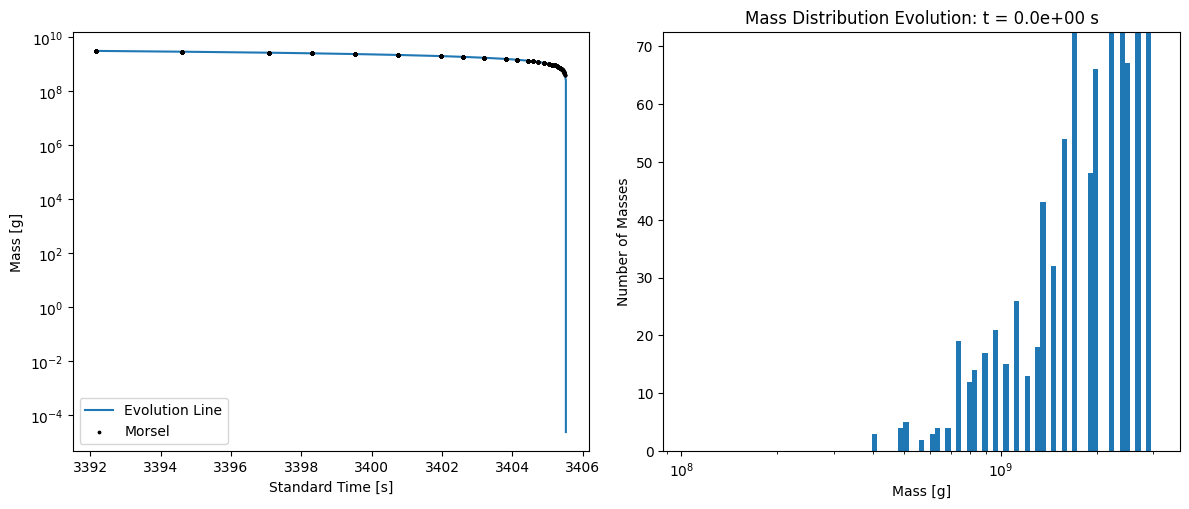

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mass_evolution_1[idx_t_evolve(mass_evolution_1, np.linspace(max(mass_dist), 0, 10000)), 0],
         mass_evolution_1[idx_t_evolve(mass_evolution_1, np.linspace(max(mass_dist), 0, 10000)), 1],
         label='Evolution Line',
         zorder=1)
pts = plt.scatter(mass_evolution_1[idx_t_evolve(mass_evolution_1, mass_dist), 0],
                  mass_dist,
                  c='k',
                  s=3,
                  label='Morsel',
                  zorder=2)
plt.xlabel('Standard Time [s]')
plt.ylabel('Mass [g]')
plt.yscale('log')
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
bins = np.logspace(np.log10(mass_dist[-1]), np.log10(mass_dist[0]), 5*n)
counts, bins, patches = plt.hist(mass_dist, bins=bins)
plt.xlabel('Mass [g]')
plt.ylabel('Number of Masses')
plt.xscale('log')
plt.tight_layout()


def animate_mass_distribution(i):
    t_max = None

    idx_mass_dist = idx_t_evolve(mass_evolution_1, mass_dist)
    idx_zero = idx_t_evolve(mass_evolution_1, [0])[0]
    t_end = mass_evolution_1[idx_zero, 0]

    # Determine step scaling
    if t_max is not None:
        t = i * t_max / 100
    else:
        t = i * t_end / 1e5

    idxs = [idx_m_evolve(mass_evolution_1, m, [t])[0] for m in mass_dist]
    x = np.minimum(t + mass_evolution_1[idx_mass_dist, 0], t_end)
    y = np.maximum(mass_evolution_1[idxs, 1], 0)
    # Set y to 0 if at the initial mass (avoid plotting dead BHs)
    y[mass_evolution_1[idxs, 1] == mass_evolution_1[np.argmax(mass_evolution_1[:, 0]), 1]] = 0

    pts.set_offsets(np.column_stack((x, y)))

    new_counts, _ = np.histogram(y, bins=bins)
    for rect, h in zip(patches, new_counts):
        rect.set_height(h)

    plt.title(f'Mass Distribution Evolution: t = {t:.1e} s')
    return pts, patches


ani = animation.FuncAnimation(fig, animate_mass_distribution, frames=100, interval=50)
ani.save('figures/mass_distribution_evolution.gif', writer='pillow', fps=20)


Time scale difference factor is 1.16e-07
Maximum mass is short of 1.69e+10 g


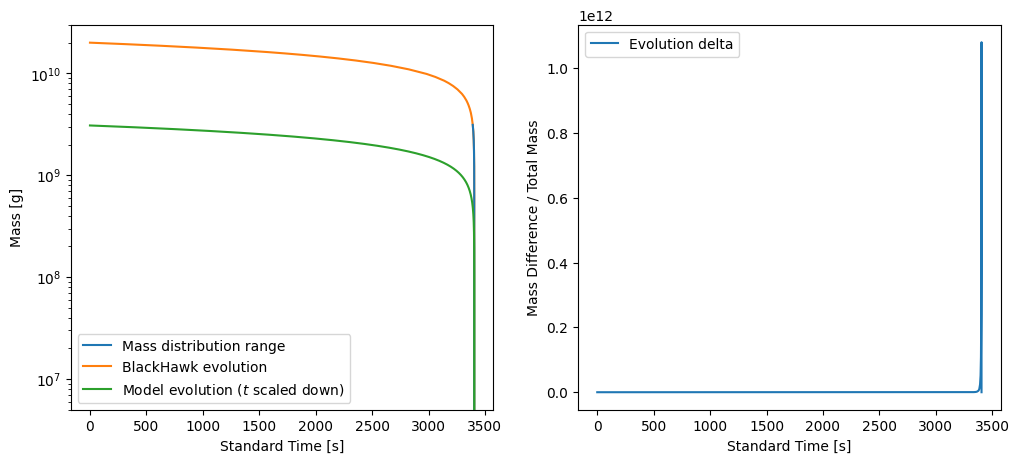

In [ ]:
time_scale_diff = (t_evolve_th(max(mass_dist), 0) / mass_evolution_1[-1,0])
print(f"Time scale difference factor is {time_scale_diff:.2e}")
print(f"Maximum mass is short of {mass_evolution_1[0,1] - max(mass_dist):.2e} g")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mass_evolution_1[idx_t_evolve(mass_evolution_1, np.linspace(max(mass_dist), 0, 10000)), 0],
         mass_evolution_1[idx_t_evolve(mass_evolution_1, np.linspace(max(mass_dist), 0, 10000)), 1],
         label='Mass distribution range',
         zorder=2)
plt.plot(mass_evolution_1[:,0],
         mass_evolution_1[:,1],
         label='BlackHawk evolution',
         zorder=1)
plt.plot(t_evolve_th(max(mass_dist), np.linspace(max(mass_dist), 0, 10000)) / time_scale_diff,
         m_evolve_th(max(mass_dist), t_evolve_th(max(mass_dist), np.linspace(max(mass_dist), 0, 10000))),
         label='Model evolution ($t$ scaled down)',
         zorder=3)
plt.xlabel('Standard Time [s]')
plt.ylabel('Mass [g]')
plt.yscale('log')
plt.ylim(5e+6, 3e+10)
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
plt.plot(t_evolve_th(max(mass_dist), np.linspace(max(mass_dist), 0, len(mass_evolution_1[:,0]))) / time_scale_diff,
         (m_evolve_th(max(mass_dist), t_evolve_th(max(mass_dist), np.linspace(max(mass_dist), 0, len(mass_evolution_1[:,1])))) - mass_evolution_1[:,1]) / mass_evolution_1[:,1],
         label='Evolution delta')
plt.xlabel('Standard Time [s]')
plt.ylabel('Mass Difference / Total Mass')
plt.legend(loc='upper left')

plt.show()


### Graph Theory

2000000000000.0002
-2000025266654.2898


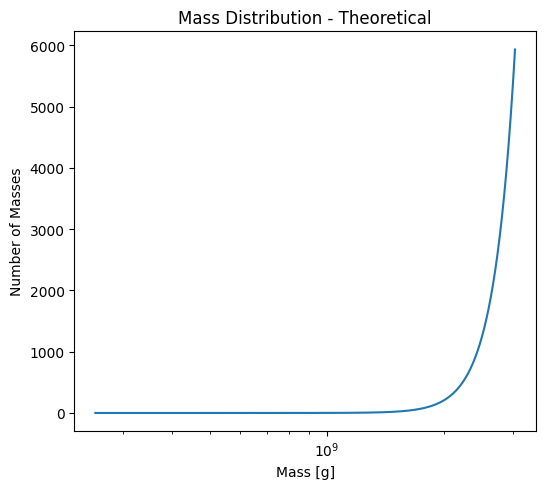

In [ ]:
density_th = [mass_distribution_th(m, dist_choice, total_mass, min(mass_dist), max(mass_dist), -alpha) for m in mass_dist]

print(np.sum(mass_dist))
print(np.trapz(density_th, mass_dist))

plt.figure(figsize=(5.56, 5))
plt.plot(mass_dist, density_th)
plt.title('Mass Distribution - Theoretical')
plt.xlabel('Mass [g]')
plt.ylabel('Number of Masses')
plt.xscale('log')
plt.tight_layout()
plt.show()


C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:92: RuntimeWarning: overflow encountered in exp
  return 1 / (2 * cst.pi * hbar_GeV * (np.exp(energy / (k_GeV * temperature_th(mass, time))) - 1))
C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:7: RuntimeWarning: invalid value encountered in scalar power
  return (mass_init ** 3 - (c * time)) ** (1/3)


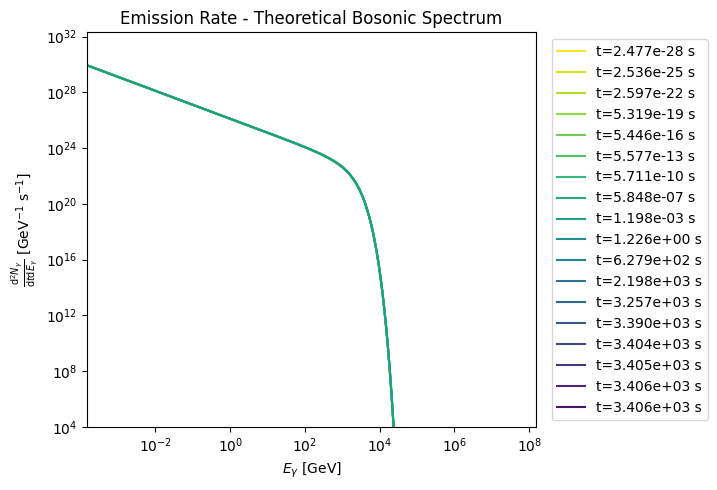

In [ ]:
e_th = np.logspace(np.log10(1e-4), np.log10(1.5e+8), 10000)

plt.figure(figsize=(7.3, 5))
for i in range(n):
    plt.plot(e_th,
             emission_rate_th(mass_evolution_1[1, 1], j[i], e_th, 1),
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Emission Rate - Theoretical Bosonic Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$\\frac{\\text{d}^2N_{\\gamma}}{\\text{d}t\\text{d}E_{\\gamma}}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+32)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig('figures/th_emission_rate.png', dpi=300)


C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral = sc.quad(lambda tau: mass_distribution_th(m_evolve_th(mass_max, tau), dist_choice, total_mass, mass_min, mass_max, alpha)
C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:92: RuntimeWarning: overflow encountered in exp
  return 1 / (2 * cst.pi * hbar_GeV * (np.exp(energy / (k_GeV * temperature_th(mass, time))) - 1))
C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can 

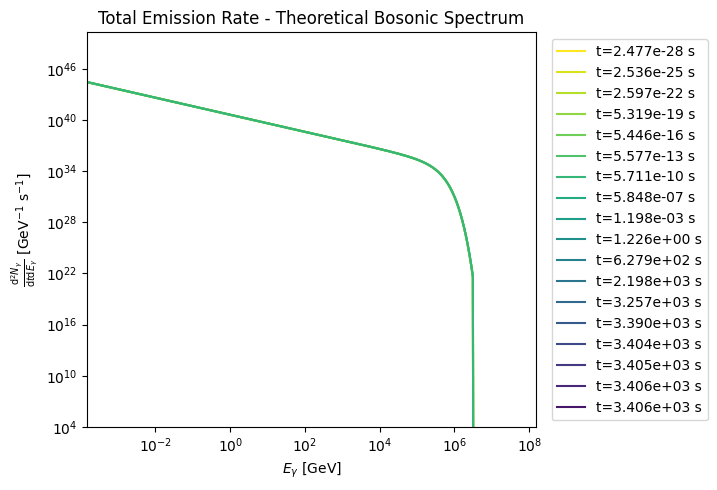

In [ ]:
e_th = np.logspace(np.log10(1e-4), np.log10(1.5e+8), 1000)

plt.figure(figsize=(7.3, 5))
for i in range(n):
    tot_em_rate = []
    for energy in e_th:
        tot_em_rate.append(total_emission_rate_th(j[i], energy, 1, dist_choice, total_mass, min(mass_dist), max(mass_dist), alpha))
    plt.plot(e_th,
             tot_em_rate,
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Total Emission Rate - Theoretical Bosonic Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$\\frac{\\text{d}^2N_{\\gamma}}{\\text{d}t\\text{d}E_{\\gamma}}$ [GeV$^{-1}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e+4, 2e+47 * nb_bm)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig('figures/th_emission_total.png', dpi=300)


C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:103: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral = sc.quad(lambda tau: mass_distribution_th(m_evolve_th(mass_max, tau), dist_choice, total_mass, mass_min, mass_max, alpha)
C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:92: RuntimeWarning: overflow encountered in exp
  return 1 / (2 * cst.pi * hbar_GeV * (np.exp(energy / (k_GeV * temperature_th(mass, time))) - 1))
C:\Users\felix\AppData\Local\Temp\ipykernel_18424\509719550.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can 

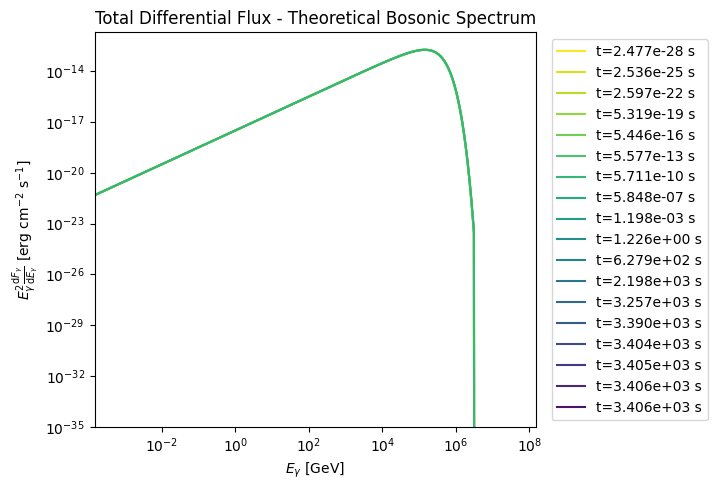

In [ ]:
e_th = np.logspace(np.log10(1e-4), np.log10(1.5e+8), 1000)

plt.figure(figsize=(7.3, 5))
for i in range(n):
    tot_em_rate = []
    for energy in e_th:
        tot_em_rate.append(total_emission_rate_th(j[i], energy, 1, dist_choice, total_mass, min(mass_dist), max(mass_dist), alpha))
    plt.plot(e_th,
             convert_to_cgs(differential_flux_th(e_th, tot_em_rate)),
             label=f't={j[i]:.3e} s',
             color=plt.cm.viridis_r(i / n))
plt.title('Total Differential Flux - Theoretical Bosonic Spectrum')
plt.xlabel('$E_{\\gamma}$ [GeV]')
plt.ylabel('$E^2_{\\gamma} \\frac{\\text{d}F_{\\gamma}}{\\text{d}E_{\\gamma}}$ [erg cm$^{-2}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e-4, 1.5e+8)
plt.ylim(1e-38 * nb_bm, 2e-15 * nb_bm * (1e+4 if time_extention else 1))
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig('figures/th_diff_flux_total.png', dpi=300)
